In [1]:
import os
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import numpy as np
import calendar
from dateutil import parser

In [2]:
SRC_DIR = os.path.dirname(os.getcwd())

In [3]:
# connect to DB
SRC_DIR = os.path.dirname(os.getcwd())
dbname = "quickbooks.db"
dbpath = os.path.join(SRC_DIR,"db",dbname)
conn = sqlite3.connect(dbpath) 
qbdf = pd.read_sql("select * from categorized_items", conn)

In [4]:
budget_file = os.path.join(SRC_DIR,'config','qb_to_budget_map.csv')
budgetdf = pd.read_csv(budget_file)

In [5]:
# data manipulation
qbdf['item'] = qbdf['category'].apply(lambda x: x.split(':')[-1])
qbdf['Amount'] = qbdf['Amount'].astype(float)
qbdf['Account_Type'] = qbdf['category'].apply(lambda x: x.split(':')[0])
qbdf['Date'] = pd.to_datetime(qbdf['Date'])

budgetdf['Budget'] = budgetdf['Budget']*12.0
budget_items = budgetdf['QB_Item'].unique()

expenses = qbdf.loc[qbdf['Account_Type']=='Expenses']
income = qbdf.loc[qbdf['Account_Type'] == 'Income']

# check for unrecognized types and categories
types = qbdf["Transaction Type"].unique()
expected_types = ['Check','Expense','Deposit']
for t in types:
    if t not in expected_types:
        print(f"Warning: {t} not a recognized type")

for item in expenses['item'].unique():
    if item not in budget_items:
        print(f"Warning: {item} not in any budget category")

In [6]:
expenses.loc[expenses['item']=='Bank Fee']

,Date,Transaction Type,Num,Name,Memo/Description,Split,Amount,Balance,category,category_level,item,Account_Type
356,2023-08-29,Expense,,Bankcard Mtot Disc,"Withdrawal Card Fee VISA INTERN Fee, Withdraw...",1002 ENT Checking (Keystone),2.21,2.21,Expenses:Bank Fee,2,Bank Fee,Expenses


In [7]:
item_totals = expenses.groupby('item').aggregate({"Amount":"sum"}).reset_index()
all_totals = pd.merge(budgetdf,item_totals, left_on='QB_Item', right_on="item", how = 'left')
subcategory_totals = all_totals.groupby("Subcategory").aggregate({"Budget":"sum","Amount":"sum"}).reset_index()

In [8]:
total_expense = expenses['Amount'].sum()
total_income = income['Amount'].sum()
net_profit = total_income - total_expense

In [9]:
year = 2023
for month in range(1,9):
    days = calendar.monthrange(year,month)[1]
    month_name = calendar.month_name[month]
    print(f"Grabbing report details for {month_name}")

Grabbing report details for January
Grabbing report details for February
Grabbing report details for March
Grabbing report details for April
Grabbing report details for May
Grabbing report details for June
Grabbing report details for July
Grabbing report details for August


## Month Specific Reports

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ind = np.arange(len(subcategory_totals))
width = 0.45
budget = ax.bar(ind, subcategory_totals['Budget'], width, label = "Budget")
actual = ax.bar(ind+width, subcategory_totals["Amount"], width, label="Actuals")
ax.set_ylabel("Monthly Expenses")
ax.set_title(month_name, fontsize=20)
midx = ind.mean()
midy = max([subcategory_totals['Budget'].max(), subcategory_totals["Amount"].max()])*0.8
color = 'green'
if net_profit>0:
    color = 'green'
else:
    color = 'red'
ax.text(midx-1, midy, 'Income: {:.2f}\nExpenses: {:.2f}\nNet Profit: {:.2f}'.format(total_income,total_expense, net_profit), fontsize=14, bbox=dict(facecolor=color, alpha=0.5))
ax.legend()

ax.set_xticks(ind+width/2, subcategory_totals['Subcategory'], rotation=90, fontsize=15)
plt.tight_layout()
plt.savefig(f'{month_name}.png')

## YTD Reports

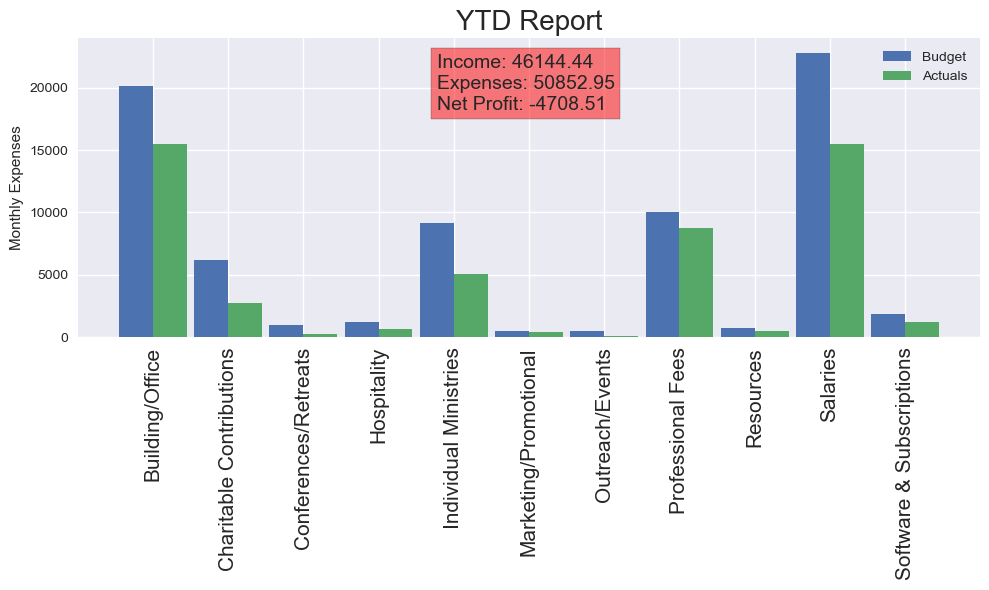

In [10]:
fig, ax = plt.subplots(figsize = (10,6))
ind = np.arange(len(subcategory_totals))
width = 0.45
budget = ax.bar(ind, subcategory_totals['Budget'], width, label = "Budget")
actual = ax.bar(ind+width, subcategory_totals["Amount"], width, label="Actuals")
ax.set_ylabel("Monthly Expenses")
ax.set_title("YTD Report", fontsize=20)
midx = ind.mean()
midy = max([subcategory_totals['Budget'].max(), subcategory_totals["Amount"].max()])*0.8
color = 'green'
if net_profit>0:
    color = 'green'
else:
    color = 'red'
ax.text(midx-1, midy, 'Income: {:.2f}\nExpenses: {:.2f}\nNet Profit: {:.2f}'.format(total_income,total_expense, net_profit), fontsize=14, bbox=dict(facecolor=color, alpha=0.5))
ax.legend()

ax.set_xticks(ind+width/2, subcategory_totals['Subcategory'], rotation=90, fontsize=15)
plt.tight_layout()
plt.savefig(f'{month_name}.png')

In [11]:
special_account = income[income['item']=="Worship Contribution"]

In [14]:
special_account[['Date','Amount','Transaction Type']]

,Date,Amount,Transaction Type
303,2023-07-05,5000.00,Deposit
304,2023-07-06,-1297.32,Expense
351,2023-08-01,1297.32,Deposit
352,2023-08-01,-1297.60,Expense
353,2023-08-08,-250.00,Check
354,2023-08-21,-600.00,Check
355,2023-08-31,-634.25,Expense


Text(0.5, 1.0, 'Worship Contribution Account Balance')

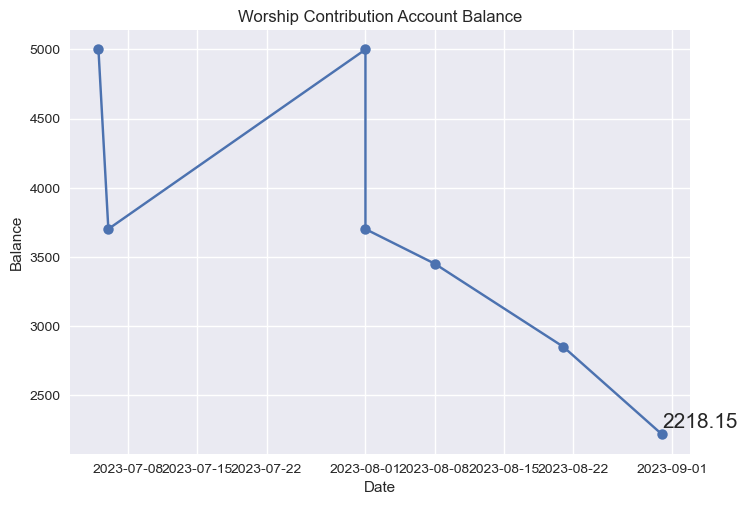

In [13]:
fig, ax = plt.subplots()
x = special_account['Date']
y = special_account['Amount'].cumsum()
ax.plot(x,y, marker='.', markersize=15)
ax.set_ylabel("Balance")
ax.set_xlabel("Date")
ax.text(list(x)[-1],list(y)[-1]+50,f"{list(y)[-1]}",size=15)
ax.set_title("Worship Contribution Account Balance")

In [15]:
all_totals[~all_totals['item'].isin(['Lead Pastor','Associate Pastor'])].sort_values(['Amount'], ascending=False).head(10)[['Category','Subcategory','item','Amount']]

,Category,Subcategory,item,Amount
7,Facilities,Building/Office,Repair and Maintenance,5822.75
6,Facilities,Building/Office,Updates/Renovations,4958.46
16,Facilities,Professional Fees,Lawn/Snow,3593.40
13,Facilities,Professional Fees,Utilities,3066.41
11,Facilities,Building/Office,Church Insurance,2265.00
23,Ministry,Individual Ministries,Ministry Network,1980.00
30,Ministry,Individual Ministries,Honorarium/Blessing,1700.00
21,Facilities,Software & Subscriptions,Software and Subscriptions,1233.15
37,Giving,Charitable Contributions,Joel Frees,887.58
36,Giving,Charitable Contributions,Life Network,882.00


In [15]:
start_time = parser.parse('2023-01-01')
end_time = parser.parse('2024-01-01')
expense_max_date = expenses['Date'].max()
income_max_date = income['Date'].max()

# trim data set to time period of interest and remove special accounts
period_expenses = expenses.loc[(expenses['Date']>=start_time) & (expenses['Amount']<4000)]
period_income = income.loc[(income['Date']>=start_time) & (income['item']!="Worship Contribution") & (income['item']!='Olive Tree (Tenant Lease)')]

expense_days = (expense_max_date - start_time).days
income_days = (income_max_date - start_time).days


expense_per_day = period_expenses['Amount'].sum() / expense_days
income_per_day = period_income['Amount'].sum() / income_days


remaining_expenses = expense_per_day * (end_time - expense_max_date).days
remaining_income = income_per_day * (end_time - income_max_date).days

projected_expense_total = remaining_expenses + expenses['Amount'].sum()
projected_income_total = remaining_income + income['Amount'].sum()

print(f"Projected Expenses: {projected_expense_total}")
print(f"Projected Income: {projected_income_total}")
print(f"Projected Net Profit: {projected_income_total-projected_expense_total}")

Projected Expenses: 71589.19
Projected Income: 63323.75582329318
Projected Net Profit: -8265.434176706825


In [20]:
print(f"Income: {income['Amount'].sum()}")
print(f"Expenses: {expenses['Amount'].sum()}")
print(f"Net Profit: {income['Amount'].sum()-expenses['Amount'].sum()}")

Income: 46144.44
Expenses: 50852.95
Net Profit: -4708.509999999995


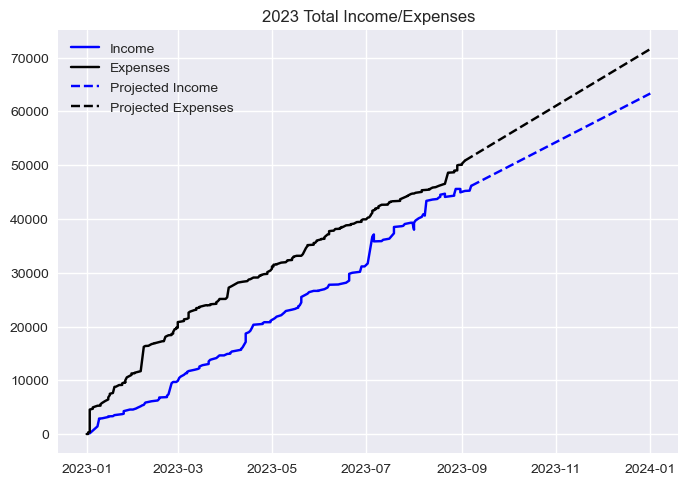

In [17]:
fig, ax = plt.subplots()
expense_line = expenses.sort_values('Date')[['Amount','Date']]
expense_line['Amount'] = expense_line['Amount'].cumsum()
income_line = income.sort_values('Date')[['Amount','Date']]
income_line['Amount'] = income_line['Amount'].cumsum()
ax.plot(income_line['Date'], income_line['Amount'], color='blue', label="Income")
ax.plot(expense_line['Date'],expense_line['Amount'], color='black', label="Expenses")
projected_income_dates = [list(income_line.tail(1)['Date'])[0], parser.parse('2024-01-01')]
projected_income_line = [list(income_line.tail(1)['Amount'])[0], projected_income_total]
projected_expense_dates = [list(expense_line.tail(1)['Date'])[0], parser.parse('2024-01-01')]
projected_expense_line = [list(expense_line.tail(1)['Amount'])[0], projected_expense_total]
ax.plot(projected_income_dates,projected_income_line,linestyle='--',color='blue', label="Projected Income")
ax.plot(projected_expense_dates,projected_expense_line,linestyle='--',color='black', label="Projected Expenses")
ax.legend()
ax.set_title("2023 Total Income/Expenses")
plt.show()

In [167]:
expense_line = pd.concat([expense_line,pd.DataFrame({'Amount':remaining_expenses,'Date':parser.parse('2024-01-01')},index=[0])])
income_line = pd.concat([income_line,pd.DataFrame({'Amount':remaining_income,'Date':parser.parse('2024-01-01')},index=[0])])

In [164]:
expense_line.iloc[1]['Date']

Timestamp('2023-01-02 00:00:00')